In [3]:
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import sys, os
from sys import argv
import ROOT
from ROOT import TH2F, TCanvas, TFile
import pandas as pd
from dataclasses import make_dataclass
import multiprocessing as mp
import mplhep as hep

Welcome to JupyROOT 6.22/08


## Part 1, read log and get fit parameters and fit fraction

### Part 1-1, read log
Every bootstrapping sample do 10 random fits.\
Use func `read_logscan` to read the output of these fit results.\
Then use `pd.groupby` and `pd.merge` to get min NLL and its result index for each bootstrapping. \

In [4]:
def read_logscan(logfile):
    """This function is used to read logfiles generated by qnFit/sort.sh.
    To read the nll, file id and fit status into a dataframe.

    Args:
        logfile (_type_): _description_

    Returns:
        dataframe: _description_
    """
    # mass: bootstrapping file; id: fit result index; nll: NLL; status;
    one_log = make_dataclass("one_log", [("id", int), ("nll",float), ("status", str)])
    df1 = pd.DataFrame()
    f1 = open(logfile,"r+")
    for l1 in f1:
        nll_temp = l1.split()[1]
        id_temp = l1.split()[0].split("//")[1].split("-")[1].split(".")[0]
        status_temp = l1.split()[3]
        df1 = df1.append([one_log(int(id_temp), float(nll_temp), str(status_temp))], ignore_index=True)
    return df1

In [5]:
# Use pd.groupby and pd.merge to get the id of minimum nll for each bootstrapping sample.
df1 = read_logscan("checklog.txt")
df1["state_undetailed"] = ""
df1["state"] = ""

df_converged = df1[df1["status"] == "CONVERGED"]
df_converged = df_converged.sort_values(by=["id"])
#list_state = ["beta_5_74", "beta_5_88", "beta_6_02", "beta_6_16", "beta_6_30", "beta_6_56"]
list_state = ["phase_00","phase_01","phase_02","phase_03","phase_04","phase_05"]
list_state_undetailed = ["phase"]
list_id = [0,100,200,300,400,500,600]
for i in range(len(list_id)-1):
    df_converged.loc[(df_converged["id"]>=list_id[i]) & (df_converged["id"]<list_id[i+1]),"state"] = list_state[i]
list_id_undetailed = [0,600]
for i in range(len(list_id_undetailed)-1):
    df_converged.loc[(df_converged["id"]>=list_id_undetailed[i]) & (df_converged["id"]<list_id_undetailed[i+1]),"state_undetailed"] = list_state_undetailed[i]
df_groupby = df_converged[["state","nll"]].groupby(by="state")["nll"].min()
df_merge = pd.merge(df_groupby,df_converged,how="left",on=["state","nll"])
#df_groupby = df_converged[["mass","nll"]].groupby(by="mass")["nll"].min()
#df_merge = pd.merge(df_groupby,df_converged,how="left",on=["mass","nll"])
#df_merge_firstid = df_merge.groupby(by="mass")["id"].min()
#df_merge = pd.merge(df_merge_firstid,df_merge,how="left",on=["mass","id"])
print(df_converged.head())
print(df_converged.shape)
print(df_merge.head())
print(df_merge.shape)
df_merge.to_csv("checklog_converged.csv",index=False)

    id      nll     status state_undetailed     state
0    0 -11118.2  CONVERGED            phase  phase_00
7    1 -11115.2  CONVERGED            phase  phase_00
17   2 -11118.1  CONVERGED            phase  phase_00
28   3 -11117.6  CONVERGED            phase  phase_00
35   4 -11129.3  CONVERGED            phase  phase_00
(535, 5)
      state      nll   id     status state_undetailed
0  phase_00 -11130.2   87  CONVERGED            phase
1  phase_01 -11130.2  142  CONVERGED            phase
2  phase_01 -11130.2  159  CONVERGED            phase
3  phase_02 -11130.1  283  CONVERGED            phase
4  phase_03 -11130.3  334  CONVERGED            phase
(8, 5)


### Part 1-2, get fit parameters
The `df_merge` could give us the fit parameters file *.func we need.\
Then use the dataframe `df_temp` to load the *.func file.\
`pd.concat` join two dataframe together according to  the same column, which is really useful.

In [6]:
title = ["SR_"+str(i).zfill(2) for i in range(0,12)]
title.extend(["SI_"+str(i).zfill(2) for i in range(0,12)])
title = ["SR_"+str(i).zfill(1) for i in range(0,6)]
title = ["SR_"+str(i).zfill(2) for i in range(0,12)]
title.extend(["SI_"+str(i).zfill(2) for i in range(0,12)])
df_original = pd.DataFrame(columns=title)
df_original = df_original.append({"id":-999,"state":-999,"state_undetailed":-999},ignore_index=True)
for i in range(0,df_merge.shape[0]):
    temp_id = df_merge.iloc[i]["id"]
    temp_state = df_merge.iloc[i]["state"]
    temp_state_undetailed = df_merge.iloc[i]["state_undetailed"]
    temp_filename = "funcs/fit-"+str(temp_id)+".func"
    temp_file = open(temp_filename,"r+")
    dict_temp = {}
    for line1 in temp_file:
        dict_temp[line1.split()[0]] = line1.split()[2]
    dict_temp["id"] = temp_id
    dict_temp["state"] = temp_state
    dict_temp["state_undetailed"] = temp_state_undetailed
    df_temp = pd.DataFrame(dict_temp,index=[0])
    df_original = pd.concat([df_original,df_temp],join="inner")
df_original = df_original[df_original["id"]>=0]
print(df_original["state"])
df_original.to_csv("fit_result.csv",index=False)

0    phase_00
0    phase_01
0    phase_01
0    phase_02
0    phase_03
0    phase_04
0    phase_04
0    phase_05
Name: state, dtype: object


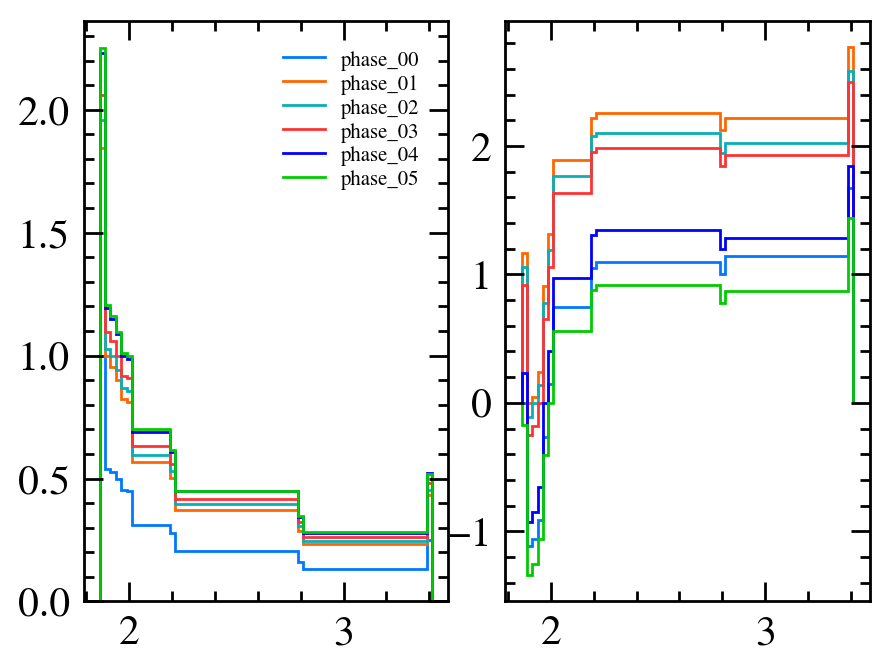

In [8]:
df_original = pd.read_csv("fit_result.csv")
for i in range(0,12):
    df_original["modulus_{0:02d}".format(i)] = np.sqrt(pow(df_original["SR_{0:02d}".format(i)],2) + pow(df_original["SI_{0:02d}".format(i)],2))
    df_original["phase_{0:02d}".format(i)] = 2*np.arctan2(df_original["SI_{0:02d}".format(i)],df_original["modulus_{0:02d}".format(i)] + df_original["SR_{0:02d}".format(i)] )
fig,axs = plt.subplots(1,2)
for i in list_state:
    df_temp = df_original[df_original["state"] == i]
    list_modulus_values = df_temp.filter(regex="modulus").values[0]
    list_phase_values = df_temp.filter(regex="phase").values[0]
    #print(list_modulus_values)
    #print(list_phase_values)

    # Define the x-edges of each histogram bin based on the bin centers
    list_dat = [1.8766,1.9,1.925,1.95,1.975,2.0,2.1,2.2,2.5,2.8,3.1,3.4]
    list_edge = [list_dat[0]-(list_dat[1]-list_dat[0])/2.0]
    for j in range(len(list_dat)):
        to_append = list_dat[j]+list_dat[j]-list_edge[j]
        list_edge.append(to_append)
    hep.style.use(hep.style.LHCb2)
    hep.histplot(list_modulus_values, bins=list_edge, label=i,ax=axs[0])
    hep.histplot(list_phase_values, bins=list_edge, label=i,ax=axs[1])

axs[0].legend(fontsize=15)
#plt.legend(fontsize=10)
plt.show()



### Part 1-4 SPline Modulus and Phase